# Shardul Nazirkar
Github - shardul1704
# Deep Learning Project to use Neural Networks like EfficientNetB0 and VGG16 to distinguish between 20 different bird species


#### Connecting to google drive to upload the data to google colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importing necessary libraries

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import os
import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import image_dataset_from_directory
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.models import Sequential
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from numpy import expand_dims
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
import logging
tf.get_logger().setLevel(logging.ERROR)
from tensorflow.keras.applications import EfficientNetB0
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

## 1.(a) Loading dataset, **Data** Exploration and Pre-processing

In [3]:
image_labels = []
folders = glob.glob('/content/drive/MyDrive/data/images/*.*')

for x in folders:
    image_labels.append(glob.glob(x + '/*.*'))
X_tr, y_tr = [], []
X_v, y_v = [], []
X_te, y_te = [], []
temp = 0
for iter in image_labels:
    iter_arr = []
    iter_label = []
    for i in iter:
        image = load_img(i, color_mode='rgb', 
        target_size = (224,224))
        image = np.array(image)
        iter_arr.append(image)
        iter_label.append(temp)
    temp += 1
    iter_arr = np.array(iter_arr)
    iter_label = np.array(iter_label)
    perc_val = len(iter_arr)*(0.15)/(len(iter_arr) - len(iter_arr)*0.7)
    X_tr1, X_te1, y_tr1, y_te1 = train_test_split(iter_arr, iter_label, 
                                                            train_size=0.7, shuffle =True)
    X_v1, X_te2, y_v1, y_te2 = train_test_split(X_te1, y_te1, 
                                                        train_size = perc_val, shuffle =True)
    X_tr.append(X_tr1)
    y_tr.append(y_tr1)
    X_v.append(X_v1)
    y_v.append(y_v1)
    X_te.append(X_te2)
    y_te.append(y_te2)

### One-hot encoding

In [4]:
X_tr = np.concatenate(X_tr, axis=0)
y_tr = np.concatenate(y_tr, axis=0)
X_v = np.concatenate(X_v, axis=0)
y_v = np.concatenate(y_v, axis=0)
X_te = np.concatenate(X_te, axis=0)
y_te = np.concatenate(y_te, axis=0)


X_train  = preprocess_input(X_tr)
X_val = preprocess_input(X_v)
X_test  = preprocess_input(X_te)
y_train = to_categorical(y_tr, num_classes=20)
y_val = to_categorical(y_v, num_classes=20)
y_test = to_categorical(y_te, num_classes=20)

In [5]:
X_train

array([[[[ 9.4060997e+01,  5.7221001e+01, -2.5680000e+01],
         [ 9.4060997e+01,  5.7221001e+01, -2.5680000e+01],
         [ 9.4060997e+01,  5.7221001e+01, -2.5680000e+01],
         ...,
         [ 1.2906100e+02,  7.4221001e+01, -2.1680000e+01],
         [ 1.2806100e+02,  7.3221001e+01, -2.2680000e+01],
         [ 1.2906100e+02,  7.5221001e+01, -2.4680000e+01]],

        [[ 9.5060997e+01,  5.8221001e+01, -2.4680000e+01],
         [ 9.4060997e+01,  5.7221001e+01, -2.5680000e+01],
         [ 9.4060997e+01,  5.7221001e+01, -2.5680000e+01],
         ...,
         [ 1.3006100e+02,  7.5221001e+01, -2.0680000e+01],
         [ 1.3006100e+02,  7.5221001e+01, -2.0680000e+01],
         [ 1.2906100e+02,  7.5221001e+01, -2.4680000e+01]],

        [[ 9.6060997e+01,  5.9221001e+01, -2.3680000e+01],
         [ 9.5060997e+01,  5.8221001e+01, -2.4680000e+01],
         [ 9.5060997e+01,  5.8221001e+01, -2.4680000e+01],
         ...,
         [ 1.2906100e+02,  7.4221001e+01, -2.1680000e+01],
         [

In [6]:
y_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

## 1.(b) Transfer Learning

## i. VGG Base model

In [7]:
VGG16_base = VGG16(weights = "imagenet", include_top = False, input_shape = (224,224,3))
VGG16_base.trainable = False 
VGG16_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## ii. VGG-16 implementation without Image augmenatation

In [8]:
flatten_layer = Flatten()
relu_layer = Dense(512, activation='relu')
dropout_layer = Dropout(0.2)
batchnormal_layer = BatchNormalization()
softmax_layer = Dense(20, activation='softmax')

final_model_1 = Sequential([VGG16_base, flatten_layer, relu_layer, dropout_layer, batchnormal_layer, softmax_layer])
final_model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 20)                10260     
                                                        

In [9]:
final_model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30,  restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('vgg16_checkpoint.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
modelfitting = final_model_1.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), batch_size=5, callbacks=[early_stop, checkpoint])

Epoch 1/50
163/164 [============================>.] - ETA: 0s - loss: 1.7618 - accuracy: 0.4957
Epoch 1: val_loss improved from inf to 0.83322, saving model to vgg16_checkpoint.h5
164/164 [==============================] - 17s 59ms/step - loss: 1.7646 - accuracy: 0.4951 - val_loss: 0.8332 - val_accuracy: 0.7368
Epoch 2/50
163/164 [============================>.] - ETA: 0s - loss: 0.4142 - accuracy: 0.9104
Epoch 2: val_loss improved from 0.83322 to 0.67026, saving model to vgg16_checkpoint.h5
164/164 [==============================] - 10s 60ms/step - loss: 0.4121 - accuracy: 0.9110 - val_loss: 0.6703 - val_accuracy: 0.7778
Epoch 3/50
163/164 [============================>.] - ETA: 0s - loss: 0.1892 - accuracy: 0.9693
Epoch 3: val_loss improved from 0.67026 to 0.62252, saving model to vgg16_checkpoint.h5
164/164 [==============================] - 9s 53ms/step - loss: 0.1885 - accuracy: 0.9695 - val_loss: 0.6225 - val_accuracy: 0.8070
Epoch 4/50
163/164 [============================>.] - 

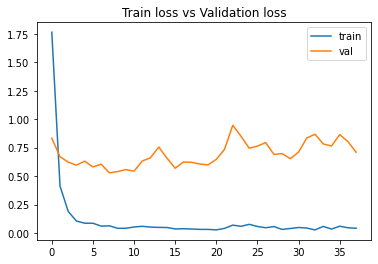

In [10]:
saved_vgg16 = load_model('vgg16_checkpoint.h5')
_, train_acc = saved_vgg16.evaluate(X_train, y_train, verbose=0)
_, val_acc = saved_vgg16.evaluate(X_val, y_val, verbose=0)
_, test_acc = saved_vgg16.evaluate(X_test, y_test, verbose=0)
plt.plot(modelfitting.history['loss'], label='train')
plt.plot(modelfitting.history['val_loss'], label='val')
plt.title("Train loss vs Validation loss")
plt.legend()
plt.show()

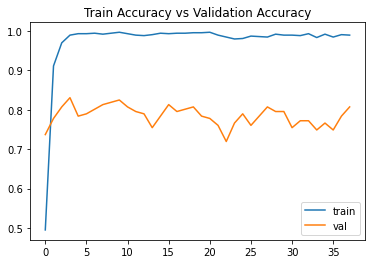

In [11]:
plt.plot(modelfitting.history['accuracy'], label='train')
plt.plot(modelfitting.history['val_accuracy'], label='val')
plt.title("Train Accuracy vs Validation Accuracy")
plt.legend()
plt.show()

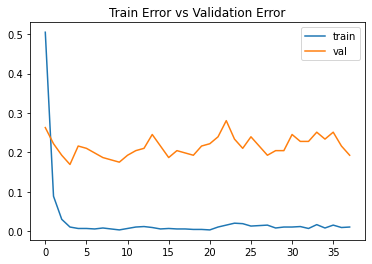

In [12]:
train_error = [1 - x for x in modelfitting.history['accuracy']]
val_error = [1 - x for x in modelfitting.history['val_accuracy']]
plt.plot(train_error, label='train')
plt.plot(val_error, label='val')
plt.title("Train Error vs Validation Error")
plt.legend()
plt.show()

In [13]:
y_preds = saved_vgg16.predict(X_test)
y_pred_classes = np.argmax(y_preds, axis=1)
print(classification_report(y_te, y_pred_classes))

6/6 [==============================] - 1s 154ms/step
              precision    recall  f1-score   support

           0       0.71      0.62      0.67         8
           1       1.00      0.89      0.94         9
           2       0.90      0.90      0.90        10
           3       0.90      1.00      0.95         9
           4       1.00      1.00      1.00         9
           5       0.69      1.00      0.82         9
           6       1.00      0.89      0.94         9
           7       0.78      0.78      0.78         9
           8       0.78      0.70      0.74        10
           9       0.73      0.89      0.80         9
          10       0.67      0.67      0.67         9
          11       1.00      0.89      0.94         9
          12       0.75      0.60      0.67        10
          13       0.67      0.60      0.63        10
          14       0.44      0.89      0.59         9
          15       1.00      0.70      0.82        10
          16       0.90     

## iii. VGG-16 implementation with Image augmenatation

In [14]:
train_datagen = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True,
                              rotation_range=5, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.2, 
                              fill_mode = 'reflect',
                              zoom_range=0.5)

val_datagen = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              rotation_range=5,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.2, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.5)

test_datagen = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              rotation_range=5,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.2, 
                              fill_mode = 'reflect',
                              zoom_range=0.5)

In [15]:
X_train_augmented = train_datagen.flow(X_train, y_train, batch_size=5, shuffle=True)
X_val_augmented = val_datagen.flow(X_val, y_val, batch_size=5, shuffle=False)
X_test_augmented = test_datagen.flow(X_test, y_test, batch_size=5, shuffle=False)

### Examples after Image augmentation

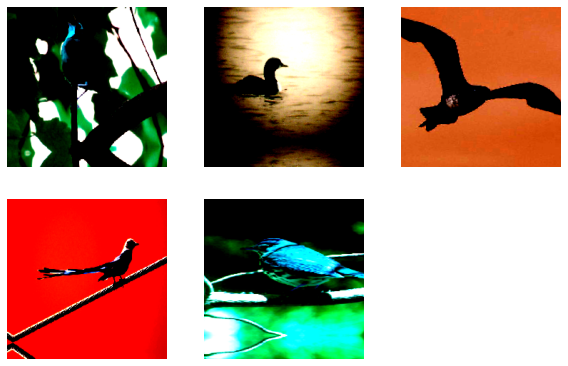

In [16]:
plt.figure(figsize = (10,10))
for i in range(5):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(X_train_augmented[6][0][i])
    plt.axis("off")

In [17]:
final_model_2 = Sequential([VGG16_base, flatten_layer, relu_layer, dropout_layer, batchnormal_layer, softmax_layer])

final_model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30,  restore_best_weights=True, verbose=1)
checkpoint2 = ModelCheckpoint('vgg16_augment_checkpoint.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

modelfitting2 = final_model_2.fit(X_train_augmented, validation_data = X_val_augmented, epochs=50, callbacks=[early_stop, checkpoint2])

Epoch 1/50
164/164 [==============================] - ETA: 0s - loss: 1.4518 - accuracy: 0.5598
Epoch 1: val_loss improved from inf to 2.51058, saving model to vgg16_augment_checkpoint.h5
164/164 [==============================] - 16s 94ms/step - loss: 1.4518 - accuracy: 0.5598 - val_loss: 2.5106 - val_accuracy: 0.2105
Epoch 2/50
164/164 [==============================] - ETA: 0s - loss: 1.2287 - accuracy: 0.6378
Epoch 2: val_loss improved from 2.51058 to 2.05182, saving model to vgg16_augment_checkpoint.h5
164/164 [==============================] - 14s 85ms/step - loss: 1.2287 - accuracy: 0.6378 - val_loss: 2.0518 - val_accuracy: 0.4035
Epoch 3/50
164/164 [==============================] - ETA: 0s - loss: 1.1813 - accuracy: 0.6598
Epoch 3: val_loss improved from 2.05182 to 1.42243, saving model to vgg16_augment_checkpoint.h5
164/164 [==============================] - 14s 86ms/step - loss: 1.1813 - accuracy: 0.6598 - val_loss: 1.4224 - val_accuracy: 0.5965
Epoch 4/50
164/164 [=========

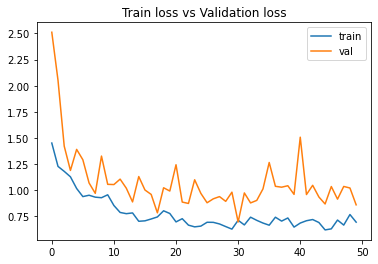

In [18]:
saved_vgg16_augment = load_model('vgg16_augment_checkpoint.h5')
_, train_acc = saved_vgg16_augment.evaluate(X_train_augmented, verbose=0)
_, val_acc = saved_vgg16_augment.evaluate(X_val_augmented, verbose=0)
_, test_acc = saved_vgg16_augment.evaluate(X_test_augmented, verbose=0)
plt.plot(modelfitting2.history['loss'], label='train')
plt.plot(modelfitting2.history['val_loss'], label='val')
plt.title("Train loss vs Validation loss")
plt.legend()
plt.show()

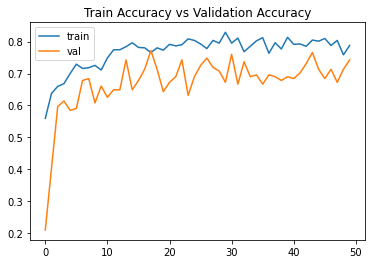

In [19]:
plt.plot(modelfitting2.history['accuracy'], label='train')
plt.plot(modelfitting2.history['val_accuracy'], label='val')
plt.title("Train Accuracy vs Validation Accuracy")
plt.legend()
plt.show()

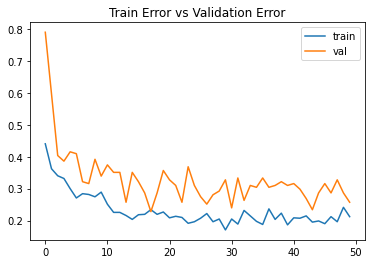

In [20]:
train_error = [1 - x for x in modelfitting2.history['accuracy']]
val_error = [1 - x for x in modelfitting2.history['val_accuracy']]
plt.plot(train_error, label='train')
plt.plot(val_error, label='val')
plt.title("Train Error vs Validation Error")
plt.legend()
plt.show()

In [21]:
y_preds = saved_vgg16_augment.predict(X_test_augmented)
y_pred_classes = np.argmax(y_preds, axis=1)
print(classification_report(y_te, y_pred_classes))

37/37 [==============================] - 3s 67ms/step
              precision    recall  f1-score   support

           0       0.62      0.62      0.62         8
           1       0.71      0.56      0.63         9
           2       0.75      0.60      0.67        10
           3       0.69      1.00      0.82         9
           4       0.86      0.67      0.75         9
           5       0.75      1.00      0.86         9
           6       0.70      0.78      0.74         9
           7       0.73      0.89      0.80         9
           8       0.67      0.60      0.63        10
           9       0.86      0.67      0.75         9
          10       0.56      0.56      0.56         9
          11       0.71      0.56      0.63         9
          12       0.60      0.90      0.72        10
          13       0.67      0.20      0.31        10
          14       0.36      0.44      0.40         9
          15       1.00      1.00      1.00        10
          16       0.80    

## iv. EfficientNetB0 Base model

In [22]:
modeleffnet = EfficientNetB0(include_top=False, weights='imagenet', input_shape = (224,224,3))
modeleffnet.trainable = False
modeleffnet.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['normalization[0][0

## v. EfficientNetB0 implementation without Image augmenatation

In [23]:
flatten_layer = Flatten()
relu_layer = Dense(512, activation='relu')
dropout_layer = Dropout(0.2)
batchnormal_layer = BatchNormalization()
softmax_layer = Dense(20, activation='softmax')

final_model_3 = Sequential([modeleffnet, flatten_layer, relu_layer, dropout_layer, batchnormal_layer, softmax_layer])
final_model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 flatten_1 (Flatten)         (None, 62720)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               32113152  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 20)                10260     
                                                      

In [24]:
final_model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30,  restore_best_weights=True, verbose=1)
checkpoint3 = ModelCheckpoint('ef_checkpoint.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
modelfitting3 = final_model_3.fit(X_tr, y_train, epochs=50, validation_data=(X_v, y_val), batch_size=5, callbacks=[early_stop, checkpoint3])

Epoch 1/50
163/164 [============================>.] - ETA: 0s - loss: 1.6807 - accuracy: 0.5276
Epoch 1: val_loss improved from inf to 1.32925, saving model to ef_checkpoint.h5
164/164 [==============================] - 14s 46ms/step - loss: 1.6771 - accuracy: 0.5280 - val_loss: 1.3293 - val_accuracy: 0.7544
Epoch 2/50
162/164 [============================>.] - ETA: 0s - loss: 0.4401 - accuracy: 0.8864
Epoch 2: val_loss improved from 1.32925 to 0.73143, saving model to ef_checkpoint.h5
164/164 [==============================] - 6s 36ms/step - loss: 0.4381 - accuracy: 0.8866 - val_loss: 0.7314 - val_accuracy: 0.8187
Epoch 3/50
162/164 [============================>.] - ETA: 0s - loss: 0.2065 - accuracy: 0.9580
Epoch 3: val_loss improved from 0.73143 to 0.63174, saving model to ef_checkpoint.h5
164/164 [==============================] - 6s 34ms/step - loss: 0.2054 - accuracy: 0.9585 - val_loss: 0.6317 - val_accuracy: 0.8012
Epoch 4/50
163/164 [============================>.] - ETA: 0s - 

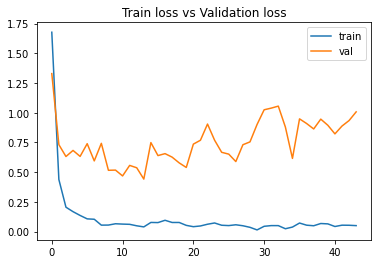

In [25]:
saved_effnet = load_model('ef_checkpoint.h5')
_, train_acc = saved_effnet.evaluate(X_train, y_train, verbose=0)
_, val_acc = saved_effnet.evaluate(X_val, y_val, verbose=0)
_, test_acc = saved_effnet.evaluate(X_test, y_test, verbose=0)
plt.plot(modelfitting3.history['loss'], label='train')
plt.plot(modelfitting3.history['val_loss'], label='val')
plt.title("Train loss vs Validation loss")
plt.legend()
plt.show()

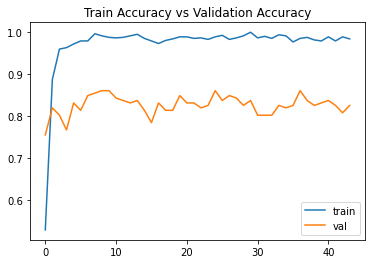

In [26]:
plt.plot(modelfitting3.history['accuracy'], label='train')
plt.plot(modelfitting3.history['val_accuracy'], label='val')
plt.title("Train Accuracy vs Validation Accuracy")
plt.legend()
plt.show()

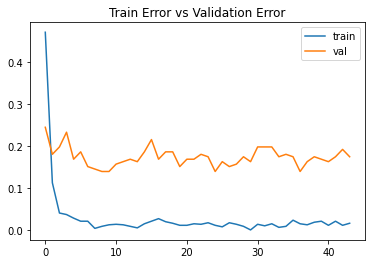

In [27]:
train_error = [1 - x for x in modelfitting3.history['accuracy']]
val_error = [1 - x for x in modelfitting3.history['val_accuracy']]
plt.plot(train_error, label='train')
plt.plot(val_error, label='val')
plt.title("Train Error vs Validation Error")
plt.legend()
plt.show()

In [28]:
y_preds = saved_effnet.predict(X_te)
y_pred_classes = np.argmax(y_preds, axis=1)
print(classification_report(y_te, y_pred_classes))

6/6 [==============================] - 2s 70ms/step
              precision    recall  f1-score   support

           0       0.83      0.62      0.71         8
           1       0.90      1.00      0.95         9
           2       0.91      1.00      0.95        10
           3       0.89      0.89      0.89         9
           4       1.00      1.00      1.00         9
           5       0.75      1.00      0.86         9
           6       0.88      0.78      0.82         9
           7       0.54      0.78      0.64         9
           8       0.88      0.70      0.78        10
           9       0.89      0.89      0.89         9
          10       1.00      0.89      0.94         9
          11       1.00      0.89      0.94         9
          12       0.83      1.00      0.91        10
          13       0.67      0.60      0.63        10
          14       0.80      0.89      0.84         9
          15       1.00      0.80      0.89        10
          16       1.00      

## vi. EfficientNetB0 implementation with Image augmenatation

In [29]:
flatten_layer = Flatten()
relu_layer = Dense(512, activation='relu')
dropout_layer = Dropout(0.2)
batchnormal_layer = BatchNormalization()
softmax_layer = Dense(20, activation='softmax')

final_model_4 = Sequential([layers.RandomZoom(0.1),
                            layers.RandomCrop(height = 224, width = 224),
                            layers.RandomRotation(0.2),
                            layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
                            layers.RandomFlip('horizontal_and_vertical'),
                            layers.RandomContrast(factor=0.6),
                            modeleffnet, flatten_layer, relu_layer, dropout_layer, batchnormal_layer, softmax_layer])

In [30]:
final_model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30,  restore_best_weights=True, verbose=1)
checkpoint4 = ModelCheckpoint('ef_augmented_checkpoint.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
modelfitting4 = final_model_4.fit(X_tr, y_train, epochs=50, validation_data=(X_v, y_val), batch_size=5, callbacks=[early_stop, checkpoint4])

Epoch 1/50
163/164 [============================>.] - ETA: 0s - loss: 2.4900 - accuracy: 0.2982
Epoch 1: val_loss improved from inf to 1.60105, saving model to ef_augmented_checkpoint.h5
164/164 [==============================] - 24s 79ms/step - loss: 2.4842 - accuracy: 0.2988 - val_loss: 1.6011 - val_accuracy: 0.6082
Epoch 2/50
163/164 [============================>.] - ETA: 0s - loss: 1.5201 - accuracy: 0.5387
Epoch 2: val_loss improved from 1.60105 to 1.08186, saving model to ef_augmented_checkpoint.h5
164/164 [==============================] - 10s 62ms/step - loss: 1.5133 - accuracy: 0.5415 - val_loss: 1.0819 - val_accuracy: 0.6725
Epoch 3/50
163/164 [============================>.] - ETA: 0s - loss: 1.2355 - accuracy: 0.6221
Epoch 3: val_loss improved from 1.08186 to 0.87818, saving model to ef_augmented_checkpoint.h5
164/164 [==============================] - 10s 63ms/step - loss: 1.2313 - accuracy: 0.6244 - val_loss: 0.8782 - val_accuracy: 0.6959
Epoch 4/50
164/164 [============

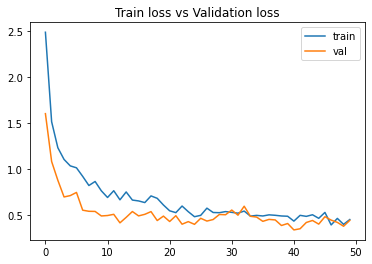

In [31]:
saved_effnet = load_model('ef_augmented_checkpoint.h5')
_, train_acc = saved_effnet.evaluate(X_train, y_train, verbose=0)
_, val_acc = saved_effnet.evaluate(X_val, y_val, verbose=0)
_, test_acc = saved_effnet.evaluate(X_test, y_test, verbose=0)
plt.plot(modelfitting4.history['loss'], label='train')
plt.plot(modelfitting4.history['val_loss'], label='val')
plt.title("Train loss vs Validation loss")
plt.legend()
plt.show()

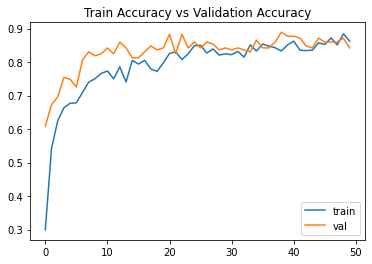

In [32]:
plt.plot(modelfitting4.history['accuracy'], label='train')
plt.plot(modelfitting4.history['val_accuracy'], label='val')
plt.title("Train Accuracy vs Validation Accuracy")
plt.legend()
plt.show()

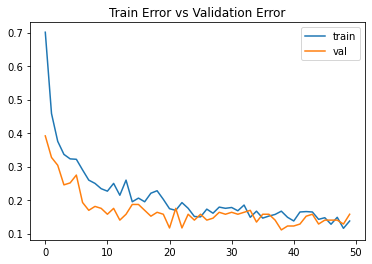

In [33]:
train_error = [1 - x for x in modelfitting4.history['accuracy']]
val_error = [1 - x for x in modelfitting4.history['val_accuracy']]
plt.plot(train_error, label='train')
plt.plot(val_error, label='val')
plt.title("Train Error vs Validation Error")
plt.legend()
plt.show()

In [34]:
y_preds = saved_effnet.predict(X_te)
y_pred_classes = np.argmax(y_preds, axis=1)
print(classification_report(y_te, y_pred_classes))

6/6 [==============================] - 3s 67ms/step
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.90      1.00      0.95         9
           2       0.83      1.00      0.91        10
           3       1.00      1.00      1.00         9
           4       1.00      1.00      1.00         9
           5       0.90      1.00      0.95         9
           6       1.00      1.00      1.00         9
           7       1.00      0.78      0.88         9
           8       0.90      0.90      0.90        10
           9       1.00      1.00      1.00         9
          10       1.00      1.00      1.00         9
          11       1.00      0.89      0.94         9
          12       1.00      0.90      0.95        10
          13       0.64      0.90      0.75        10
          14       0.80      0.89      0.84         9
          15       1.00      0.90      0.95        10
          16       1.00      